In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [28]:
metadata = pd.read_csv('datasets/top_20_descriptions.csv')
raw_data = pd.read_csv('datasets/top20_raw.csv')

/tmp/ipykernel_123394/1307700360.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


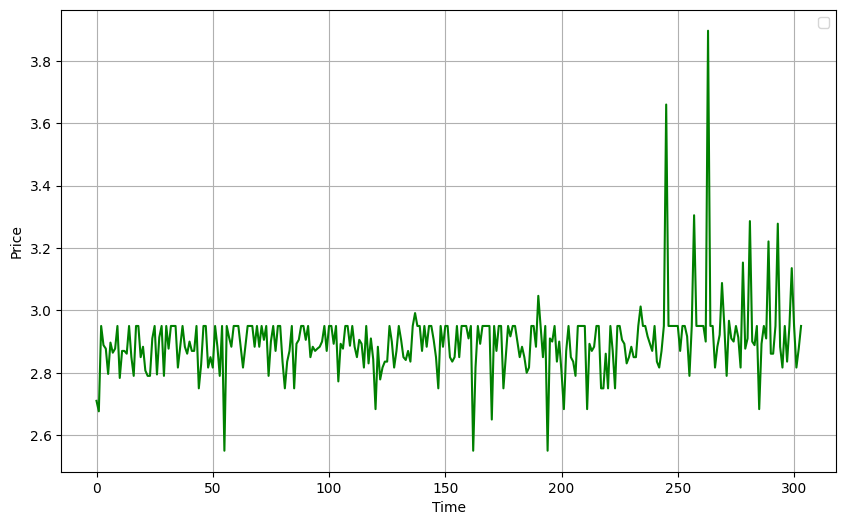

In [31]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == '85123A']['UnitPrice'].to_numpy(), color='green')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_123394/3144029345.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


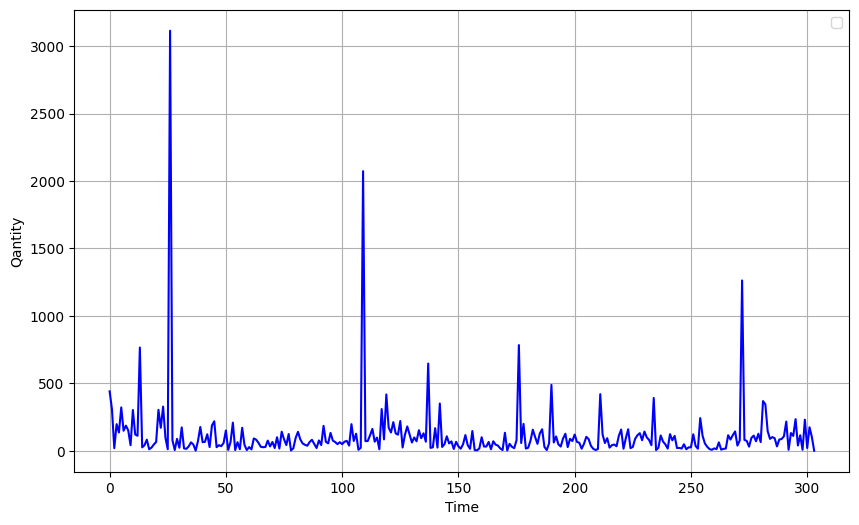

In [32]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == '85123A']['Quantity'].to_numpy(), color='blue')
plt.xlabel('Time')
plt.ylabel('Qantity')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
def LR_model(X, y):

    # Split the data into training and testing sets
    if X.shape[0] < 10:
        print("No enough data to train or test the model.")
        return
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the linear regression model with intercept
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    # mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "intercept": model.intercept_,
        "coefficients": model.coef_,
        "r2": r2
    }
def LR_model_raw(X_train, X_test, y_train, y_test):
    # Create and train the linear regression model with intercept
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    # mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "intercept": model.intercept_,
        "coefficients": model.coef_,
        "r2": r2
    }

In [11]:
def add_Fourier(data: pd.DataFrame) -> pd.DataFrame:
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%Y-%m-%d')
    data['day_of_year'] = data['InvoiceDate'].dt.dayofyear  # Convert date to day index
    # Define Fourier terms (e.g., yearly seasonality with 3 harmonics)
    num_harmonics = 3
    period = 365  # Assuming daily data

    for k in range(1, num_harmonics + 1):
        data[f'sin_{k}'] = np.sin(2 * np.pi * k * data['day_of_year'] / period)
        data[f'cos_{k}'] = np.cos(2 * np.pi * k * data['day_of_year'] / period)

    data.drop(columns=['day_of_year'], inplace=True)  # Remove intermediate column
    return data

In [12]:
results = []
models = {}
target_prodcucts = metadata['StockCode'].unique()
np.random.seed(42)  # Set random seed for reproducibility
for stock_code in target_prodcucts:
    print(f"Processing stock code: {stock_code}")
    data = raw_data[raw_data['StockCode'] == stock_code][['UnitPrice', 'Quantity', 'InvoiceDate']]
    data.reset_index(drop=True, inplace=True)
    data['LogUnitPrice'] = np.log(data['UnitPrice'].abs().replace(0, np.nan).dropna())
    data['LogQuantity'] = np.log(data['Quantity'].abs().replace(0, np.nan).dropna())

    # Define sliding window size (e.g., past 3 weeks)
    window_size = 21  # 3 weeks (assuming daily data)
    # Create rolling window features
    data['price_ma_3w'] = data['UnitPrice'].rolling(window=window_size).mean()
    data['price_std_3w'] = data['UnitPrice'].rolling(window=window_size).std()

    # Create Fourier terms for Seaonality
    data = add_Fourier(data)
    # Drop rows with NaN values
    data.dropna(inplace=True)
    if data.shape[0] < 10:
        print("No enough data to train or test the model.")
        continue
    # generate a random sequence with a size of len(data) * 0.8
    random_sequence = np.random.choice(len(data), size=int(len(data) * 0.8), replace=False)
    
    # Split the data into training and testing sets
    train_data = data.iloc[random_sequence]
    test_data = data.drop(data.index[random_sequence])
    # only clip outliers in training data
    train_data['LogUnitPrice'] = train_data['LogUnitPrice'].clip(lower=train_data['LogUnitPrice'].quantile(0.05), upper=train_data['LogUnitPrice'].quantile(0.95))
    train_data['LogQuantity'] = train_data['LogQuantity'].clip(lower=train_data['LogQuantity'].quantile(0.05), upper=train_data['LogQuantity'].quantile(0.95))
    X_train = train_data[['LogUnitPrice', 'price_ma_3w', 'price_std_3w', \
                            'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']].to_numpy() # SW +FW
    # X_train = train_data[['LogUnitPrice', 'price_ma_3w', 'price_std_3w']].to_numpy() # SW
    # X_train = train_data[['LogUnitPrice']].to_numpy() # Naive
    y_train = train_data['LogQuantity'].to_numpy()
    X_test = test_data[['LogUnitPrice', 'price_ma_3w', 'price_std_3w', \
                            'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']].to_numpy()
    # X_test = test_data[['LogUnitPrice', 'price_ma_3w', 'price_std_3w']].to_numpy()
    # X_test = test_data[['LogUnitPrice']].to_numpy()
    y_test = test_data['LogQuantity'].to_numpy()
    # Train the model
    result = LR_model_raw(X_train, X_test, y_train, y_test)
    if result:
        results.append(f'({stock_code}) {metadata[metadata['StockCode'] == stock_code]['Description'].values[0]}: {result["r2"]}')
        models[stock_code] = {"intercept": result["intercept"], "coefficients": result["coefficients"]}
    

Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 22086
Processing stock code: 22386
Processing stock code: 82484
Processing stock code: 22470
Processing stock code: 85099B
Processing stock code: 79321


/tmp/ipykernel_123394/2322934364.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['LogUnitPrice'] = train_data['LogUnitPrice'].clip(lower=train_data['LogUnitPrice'].quantile(0.05), upper=train_data['LogUnitPrice'].quantile(0.95))
/tmp/ipykernel_123394/2322934364.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['LogQuantity'] = train_data['LogQuantity'].clip(lower=train_data['LogQuantity'].quantile(0.05), upper=train_data['LogQuantity'].quantile(0.95))
/tmp/ipykernel_123394/2322

Processing stock code: 22197
Processing stock code: 22502
Processing stock code: 22178
Processing stock code: 85099F
Processing stock code: 21137
Processing stock code: 22423
Processing stock code: 47566
Processing stock code: 23166
Processing stock code: 23284
Processing stock code: 23298
Processing stock code: 23203
Processing stock code: 23843
No enough data to train or test the model.


/tmp/ipykernel_123394/2322934364.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['LogUnitPrice'] = train_data['LogUnitPrice'].clip(lower=train_data['LogUnitPrice'].quantile(0.05), upper=train_data['LogUnitPrice'].quantile(0.95))
/tmp/ipykernel_123394/2322934364.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['LogQuantity'] = train_data['LogQuantity'].clip(lower=train_data['LogQuantity'].quantile(0.05), upper=train_data['LogQuantity'].quantile(0.95))
/tmp/ipykernel_123394/2322

# Save Results for Model Comparison

In [30]:
with open('results/price_only_train_outliers.txt', 'w') as file:
    for result in results:
        file.write(result + '\n')

In [ ]:
from collections import defaultdict
rslt_dict = defaultdict(list)

# Read lines from the text file
with open('results/price_only_train_outliers.txt', 'r') as file:
    lines = file.readlines()

for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

# Read lines from the text file
with open('results/SW_results_price_only_train_outliers.txt', 'r') as file:
    lines = file.readlines()
    
# rslt_dict = defaultdict(list)
for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

# Read lines from the text file
with open('results/SW_results_season_FW_price_only_train_outliers.txt', 'r') as file:
    lines = file.readlines()
    
# rslt_dict = defaultdict(list)
for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

In [32]:
rslt_df = pd.DataFrame.from_dict(rslt_dict, orient='index', columns=['Naive LR', 'LR with Sliding Window', 'LR with Sliding Window and Fourier'])
rslt_df.reset_index(inplace=True)
rslt_df.rename(columns={'index': 'StockCode'}, inplace=True)
rslt_df.head()

,StockCode,Naive LR,LR with Sliding Window,LR with Sliding Window and Fourier
0,(85123A),-0.207395,-0.202387,-0.143169
1,(84879),0.427817,0.443653,0.540687
2,(22086),-0.048625,0.241137,0.197151
3,(22386),-0.031222,0.241694,0.265204
4,(82484),-0.041403,-0.101080,-0.091007


In [33]:
rslt_df.to_csv('model_comparison.csv', index=False)

In [34]:
rslt_df.head()

,StockCode,Naive LR,LR with Sliding Window,LR with Sliding Window and Fourier
0,(85123A),-0.207395,-0.202387,-0.143169
1,(84879),0.427817,0.443653,0.540687
2,(22086),-0.048625,0.241137,0.197151
3,(22386),-0.031222,0.241694,0.265204
4,(82484),-0.041403,-0.101080,-0.091007


In [13]:
import pickle

# Save the models dictionary to a file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(models, file)

# Apply Model to the Next Year

In [21]:
promote_df = pd.read_csv('promote.csv')
promote_df.dropna(inplace=True)
promote_df.rename(columns={'Unnamed: 0': 'StockCode'}, inplace=True)
promote_df.head()


,StockCode,12/1/2011,12/2/2011,12/3/2011,12/5/2011,12/6/2011,12/7/2011,12/8/2011,12/9/2011,12/10/2011,...,3/21/2012,3/22/2012,3/23/2012,3/24/2012,3/26/2012,3/27/2012,3/28/2012,3/29/2012,3/30/2012,3/31/2012
0,85123A,1.61,1.60,1.82,1.84,3.60,1.84,1.86,1.86,1.55,...,161.00,1.87,1.78,1.85,1.77,1.87,1.79,1.86,1.79,1.79
1,84879,0.94,0.86,1.60,0.94,1.63,0.77,0.92,0.89,1.68,...,0.91,0.88,0.92,0.92,0.85,0.94,0.93,0.91,0.75,0.93
2,21212,0.67,0.68,1.88,0.80,0.60,0.84,0.85,0.85,0.78,...,1.84,0.80,0.80,1.80,0.78,0.84,0.84,0.85,0.85,0.83
3,21977,0.64,0.50,1.51,0.68,0.66,1.43,0.69,0.65,0.65,...,0.69,0.68,0.61,0.67,0.63,0.63,0.67,0.61,2.38,0.67
4,85099B,1.25,1.41,3.04,1.40,1.19,1.18,1.39,1.41,3.02,...,2.99,1.46,1.19,1.46,1.40,1.41,1.44,1.40,1.37,1.45


In [22]:
# Melt the dataframe to transform columns into rows#
new_df = promote_df.melt(id_vars=['StockCode'], var_name='InvoiceDate', value_name='UnitPrice')
new_df['InvoiceDate'] = pd.to_datetime(new_df['InvoiceDate'], format='%m/%d/%Y')
new_df.head()

,StockCode,InvoiceDate,UnitPrice
0,85123A,2011-12-01,1.61
1,84879,2011-12-01,0.94
2,21212,2011-12-01,0.67
3,21977,2011-12-01,0.64
4,85099B,2011-12-01,1.25


In [23]:
raw_data = pd.concat([raw_data, new_df], ignore_index=True)
raw_data.head()

,StockCode,InvoiceDate,Quantity,UnitPrice
0,21137,2010-12-01,540.0,3.39
1,21137,2010-12-02,73.0,3.57
2,21137,2010-12-05,24.0,3.39
3,21137,2010-12-06,504.0,3.39
4,21137,2010-12-08,8.0,3.75


In [49]:
raw_data['InvoiceDate'] = pd.to_datetime(raw_data['InvoiceDate'], format='%Y-%m-%d')

In [17]:
with open('best_model.pkl', 'rb') as file:
    loaded_models = pickle.load(file)

In [24]:
results = {}
target_prodcucts = promote_df['StockCode'].unique()
for stock_code in target_prodcucts:
    print(f"Processing stock code: {stock_code}")
    if stock_code not in loaded_models:
        print(f"Model for stock code {stock_code} not found.")
        continue
    model_params = loaded_models[stock_code]
    model = LinearRegression()
    model.intercept_ = model_params['intercept']
    model.coef_ = model_params['coefficients']

    # Prepare the data for prediction
    data = raw_data[(raw_data['StockCode'] == stock_code) & (raw_data['InvoiceDate'] >= pd.to_datetime('2011-12-01'))][['UnitPrice', 'Quantity', 'InvoiceDate']]
    data['LogUnitPrice'] = np.log(data['UnitPrice'].abs().replace(0, np.nan).dropna())

    # Define sliding window size (e.g., past 3 weeks)
    window_size = 21  # 3 weeks (assuming daily data)
    # Create rolling window features
    data['price_ma_3w'] = data['UnitPrice'].rolling(window=window_size).mean()
    data['price_std_3w'] = data['UnitPrice'].rolling(window=window_size).std()
    # Create Fourier terms for Seaonality
    data = add_Fourier(data)

    inputs = data[['LogUnitPrice', 'price_ma_3w', 'price_std_3w', \
                               'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']].dropna().to_numpy()
    # Make predictions
    y_pred = model.predict(inputs)
    # reverse log transformation on predicted values
    # y_pred = np.exp(y_pred)
    results[stock_code] = y_pred

    

Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 21212
Model for stock code 21212 not found.
Processing stock code: 21977
Model for stock code 21977 not found.
Processing stock code: 85099B
Processing stock code: 22197
Processing stock code: 22178
Processing stock code: 22616
Model for stock code 22616 not found.
Processing stock code: 17003
Model for stock code 17003 not found.
Processing stock code: 84077
Model for stock code 84077 not found.


In [25]:
results['84879']

array([37.94671851, 48.14423406, 41.2866322 , 43.0003703 , 38.03399517,
       39.10912963, 36.41193001, 34.42616218, 39.80451972, 38.01629437,
       33.98339665, -0.50905972, 49.30070303, 35.25423979,  3.17268991,
       35.82380048, 36.46543515, 38.77788105, 37.3669141 , 38.02393827,
       36.00307684, 38.74748537, 36.67464401, 47.14980664, 38.12867931,
       35.48000778, 39.60756445, 38.88125146, 38.15819971, 46.33185202,
       38.1322671 , 43.17698522, 36.8470658 , 38.99160413, 33.55462555,
       38.33259292, -1.14036018, 35.64015411, 39.11492682, 35.66672197,
       35.03660547, 33.09871961, 37.81062211, 33.1506006 , 34.52444391,
       38.62739362, 39.34670311, 34.58796582, 38.69578717, 35.29921432,
       39.47929706, 34.06238831, 34.79252937, 36.82486457, 39.63226702,
       33.54870444,  1.78326265, 34.20418066, 33.60600244, 46.49521868,
       33.63323968, 37.64097615, 36.27925162, 33.68384762, 37.01336736,
       46.5596082 , 33.71010707, 38.4263671 , 35.05129362, 35.08

In [6]:
raw_data['InvoiceDate'] = pd.to_datetime(raw_data['InvoiceDate'], format='%Y-%m-%d')

/tmp/ipykernel_123394/1379689656.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


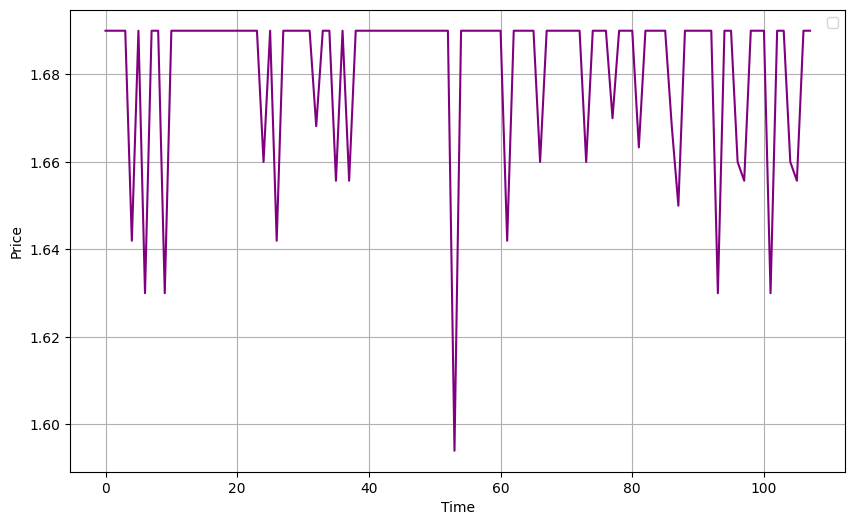

In [7]:
price_this_year_sample = raw_data[(raw_data['StockCode'] == '84879') & (raw_data['InvoiceDate'] >= pd.to_datetime('2011-12-01'))]['UnitPrice']
price_last_year_sample = raw_data[raw_data['StockCode'] == '84879']['UnitPrice'].dropna().tail(100).to_numpy()
price_vis = np.concatenate((price_last_year_sample, price_this_year_sample.to_numpy()[:10]))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(price_vis, color='purple')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
quantity_last_year_sample = raw_data[raw_data['StockCode'] == '84879']['Quantity'].dropna().tail(100).to_numpy()
vis = np.concatenate((quantity_last_year_sample, np.exp(results['84879'][:10])))
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(vis, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Predicted Quantity')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()